# 基于MindSpore 德国信用数据二分类

## package import

In [1624]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import mindspore as ms
from mindspore import nn
from mindspore import dataset
from mindspore.train.callback import LossMonitor
from mindspore import ops
from mindspore.ops import operations as P

## read data

In [1625]:
data = pd.read_csv('german_credit_data.csv')

## hyper parameter

In [1626]:
learning_rate = 0.1
epochs = 120
batch_size = 16
pred_threshold = 0.5
DS_SPLIT = [0.75, 0.05, 0.2] # train, val, test

### set same seed

In [1627]:
ms.set_seed(777)
np.random.seed(777)

## process data

### get pred features

In [1628]:
predictive_features = [ f for f in list(data.columns.values) if f not in ['id', 'label']]

print( predictive_features)

['duration_months', 'credit_amount', 'installment_rate', 'present_residence_since', 'age_years', 'number_existing_credits', 'checking_status', 'credit_history', 'purpose', 'savings_account', 'present_employment_since', 'debtors_guarantors', 'property', 'installment_plans', 'housing', 'job', 'number_people_liable', 'telephone', 'foreign_worker', 'gender']


### seperate num & categorial

In [1629]:
ctg_features = [f for f in list(data.select_dtypes(include='object')) if f in predictive_features]
num_features = [f for f in predictive_features if f not in ctg_features]

print(ctg_features)
print(num_features)

['checking_status', 'credit_history', 'purpose', 'savings_account', 'present_employment_since', 'debtors_guarantors', 'property', 'installment_plans', 'housing', 'job', 'telephone', 'foreign_worker', 'gender']
['duration_months', 'credit_amount', 'installment_rate', 'present_residence_since', 'age_years', 'number_existing_credits', 'number_people_liable']


### save to training data

In [1630]:
Y = np.array(list(data['label']), np.float32).reshape(-1,1)

X = data[predictive_features]

prefix_feature = {'checking_status':'A1',
               'credit_history':'A3',
               'purpose':'A4',
               'savings_account':'A6', 
               'present_employment_since':'A7', 
               'debtors_guarantors':'A10', 
               'property':'A12', 
               'installment_plans':'A14', 
               'housing':'A15', 
               'job':'A17', 
               'telephone':'A19', 
               'foreign_worker':'A20'}
for f in num_features:
    for index, element in enumerate(X[f]):
        X.loc[index, f] = float(element)

for f in ctg_features:
    for index, element in enumerate(X[f]):
        if f=='gender':
            X.loc[index, f] = 1. if element=='male' else .0
        else:
            X.loc[index, f] = float(element.replace(prefix_feature[f],''))


X = np.array(X.values.tolist(), np.float32)

# nomalization
X = (X-np.mean(X,axis=0))/np.std(X,axis=0)


### train-test split

In [1631]:
MyDataset = dataset.NumpySlicesDataset((X,Y),['X','y'], shuffle=False)
ds_train,ds_val, ds_test = MyDataset.split(sizes=DS_SPLIT, randomize=True)

In [1632]:
print(ds_train.get_dataset_size())

750


### batch

In [1633]:
ds_train = ds_train.shuffle(buffer_size=800).batch(batch_size)# , drop_remainder=True
ds_val = ds_val.batch(batch_size)
ds_test = ds_test.batch(batch_size)
# print(ds_train.get_dataset_size())

## Train

### loss

In [1634]:
class Loss (nn.Cell):
    def __init__(self):
        super(Loss, self).__init__()
        self.sigmoid_cross_entropy = P.SigmoidCrossEntropyWithLogits()
        self.reduce_mean = P.ReduceMean()

    def construct(self, logits, labels):
        loss = self.sigmoid_cross_entropy(logits, labels)
        loss =  (loss[0] + 5 * loss[1])/6
        loss = self.reduce_mean(loss)
        return loss

### model

In [1635]:
class Network(nn.Cell):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_sequential = nn.SequentialCell(
            nn.Dense(20, 32),
            nn.ReLU(),
            nn.Dense(32, 64),
            # nn.ReLU(),
            nn.Dense(64, 64),
            # nn.ReLU(),
            nn.Dense(64, 32),
            nn.ReLU(),
            # nn.Dropout(keep_prob=0.5),
            # nn.ReLU(),
            # nn.Dense(20, 17),
            # nn.ReLU(),
            # nn.Dense(17,17),
            # nn.ReLU(),
            nn.Dense(32, 1),
        )
        self.sigmoid = nn.Sigmoid()

    def construct(self, x):
        x = self.flatten(x)
        x = self.linear_sequential(x)
        x = self.sigmoid(x)
        return x


In [1636]:
net = Network()
loss = Loss()
opt = nn.optim.Adam(net.trainable_params(), learning_rate=learning_rate)
# myModel = ms.train.Model(net, loss, opt)
# myModel.train(epochs, ds_train, callbacks=[LossMonitor(per_print_times=100)], dataset_sink_mode=False)

### train loop

In [1637]:
def train_loop(model, dataset, loss_fn, optimizer):
    # Define forward function
    def forward_fn(data, label):
        logits = model(data)
        loss = loss_fn(logits, label)
        return loss, logits

    # Get gradient function
    grad_fn = ops.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=True)

    # Define function of one-step training
    def train_step(data, label):
        (loss, _), grads = grad_fn(data, label)
        loss = ops.depend(loss, optimizer(grads))
        return loss

    num_batches = dataset.get_dataset_size()
    tot_loss = 0
    model.set_train()
    for batch, (data, label) in enumerate(dataset.create_tuple_iterator()):
        loss = train_step(data, label)
        # if batch % 100 == 0:
        #     loss, current = loss.asnumpy(), batch
        #     print(f"loss: {loss:>7f}  [{current:>3d}/{size:>3d}]")
    model.set_train(False)
    total, train_loss, correct = 0, 0, 0
    for data, label in dataset.create_tuple_iterator():
        pred = model(data)
        total += len(data)
        train_loss += loss_fn(pred, label).asnumpy()
        pred = np.where(pred > pred_threshold, 1, 0)
        correct += np.sum([pred==label])
    train_loss /= num_batches
    correct /= total
    return correct, train_loss


### val loop

In [1638]:
def val_loop(model, dataset, loss_fn):
    model.set_train(False)
    num_batches = dataset.get_dataset_size()
    total, val_loss, correct = 0, 0, 0
    for data, label in dataset.create_tuple_iterator():
        pred = model(data)
        total += len(data)
        val_loss += loss_fn(pred, label).asnumpy()
        pred = np.where(pred > pred_threshold, 1, 0)
        correct += np.sum([pred==label])
    val_loss /= num_batches
    correct /= total
    return correct, val_loss

## Test

In [1639]:
def Test(model, dataset, loss_fn):
    num_batches = dataset.get_dataset_size()
    model.set_train(False)
    total, test_loss, correct = 0, 0, 0
    for data, label in dataset.create_tuple_iterator():
        pred = model(data)
        # print(pred)
        total += len(data)
        test_loss += loss_fn(pred, label).asnumpy()
        pred_label = np.where(pred > pred_threshold, 1, 0)
        correct += np.sum([pred_label==label])
    test_loss /= num_batches
    correct /= total
    return correct, test_loss
    # print(f" Test Acc: {(100*correct):>0.2f}%, loss: {test_loss:>8f}")


## main : start training!

In [1640]:
train_acc_his , val_acc_his = [], []
train_loss_his, val_loss_his = [], []
for epoch in tqdm(range(epochs)):
    train_acc, train_loss =train_loop(net, ds_train, loss, opt)
    val_acc, val_loss = val_loop(net,ds_val, loss)
    train_acc_his.append(train_acc)
    val_acc_his.append(val_acc)
    train_loss_his.append(train_loss)
    val_loss_his.append(val_loss)


100%|██████████| 120/120 [03:49<00:00,  1.92s/it]


In [1641]:
test_acc, test_loss = Test(net, ds_test, loss)
print(f" Test Acc: {(100*test_acc):>0.2f}%, loss: {test_loss:>8f}")

 Test Acc: 75.00%, loss: 0.693147


## show train result

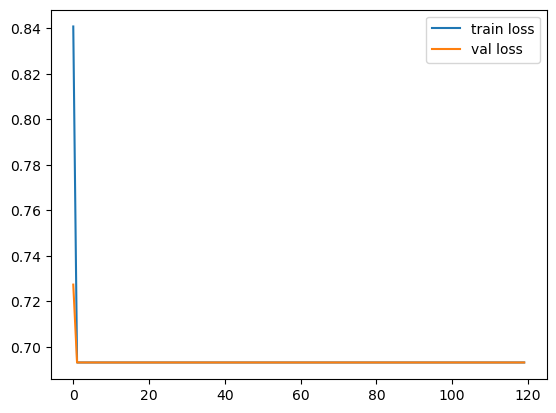

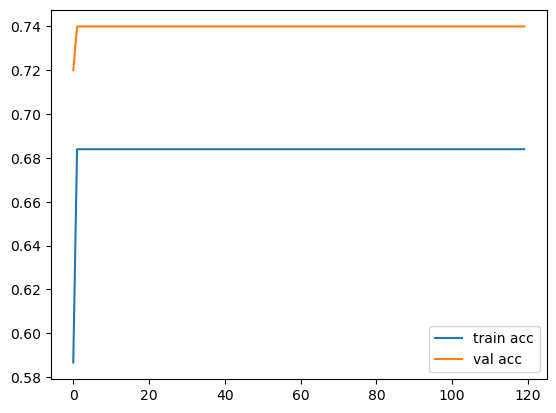

In [1642]:
plt.figure()
plt.plot(train_loss_his,label='train loss')
plt.plot(val_loss_his,label='val loss')
plt.legend()


plt.figure()
plt.plot(train_acc_his,label='train acc')
plt.plot(val_acc_his,label='val acc')
plt.legend()

plt.show()